In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
from argparse import ArgumentParser
from functools import partial
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from graspy.cluster import GaussianCluster
from graspy.embed import MultipleASE, OmnibusEmbed
from graspy.models import SBMEstimator
from graspy.plot import heatmap
from graspy.simulations import er_np, sbm
from joblib import Parallel, delayed
from scipy.stats import ttest_ind
from sklearn.metrics import adjusted_rand_score

from src import generate_truncnorm_sbms

import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

/env/miniconda3/envs/dnd/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.mixture.gaussian_mixture module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.mixture. Anything that cannot be imported from sklearn.mixture is now part of the private API.
  warnings.warn(message, FutureWarning)


<IPython.core.display.Javascript object>

In [3]:
def estimate_embeddings(X, Y, method):
    """
    Parameters
    ----------
    method : str
        Must be {'mase', 'omni'}
    """
    stacked = np.vstack([X, Y])

    if method == "mase":
        embedder = MultipleASE(2)
        embeddings = embedder.fit_transform(stacked)
    elif method == "omni":
        embedder = OmnibusEmbed(2)
        embeddings = embedder.fit_transform(stacked).mean(axis=0)
    else:
        assert ValueError("Invalid embedding method")

    return embeddings


def estimate_community(embeddings, true_labels, method, n_clusters):
    predicted_labels = GaussianCluster(n_clusters, n_clusters, "all").fit_predict(
        embeddings
    )

    # Label flipping
    idx = true_labels == 0
    if np.mean(predicted_labels[idx]) < 0.5:
        ari = adjusted_rand_score(true_labels, predicted_labels)
        return predicted_labels, ari
    else:
        # This is bitwise flipping. Turns all 0s to 1s and 1s to 0s.
        # Reason is to make labels consistent across repetitions
        # predicted_labels = predicted_labels ^ (predicted_labels & 1 == predicted_labels)
        ari = adjusted_rand_score(true_labels, predicted_labels)
        return predicted_labels, ari

<IPython.core.display.Javascript object>

In [4]:
def run_experiment(m, block_1, block_2, mean_1, mean_2, var_1, var_2, n_clusters, reps):
    omni_corrects = np.zeros((reps, len(n_clusters) * 2))
    mase_corrects = np.zeros((reps, len(n_clusters) * 2))
    omni_aris = np.zeros((reps, len(n_clusters)))
    mase_aris = np.zeros((reps, len(n_clusters)))

    for i in np.arange(reps).astype(int):
        pop1, pop2, true_labels = generate_truncnorm_sbms(
            m=m,
            block_1=block_1,
            block_2=block_2,
            mean_1=mean_1,
            mean_2=mean_2,
            var_1=var_1,
            var_2=var_2,
        )
        mase_corrects_tmp = []
        omni_corrects_tmp = []
        mase_aris_tmp = []
        omni_aris_tmp = []
        for method in ["mase", "omni"]:
            embeddings = estimate_embeddings(pop1, pop2, method)

            for k in n_clusters:
                predicted_labels, ari = estimate_community(
                    embeddings, true_labels, method, k
                )

                uniques, counts = np.unique(
                    predicted_labels[:block_1], return_counts=True
                )
                b1_max_label = uniques[np.argmax(counts)]
                b1_correct = (predicted_labels[:block_1] == b1_max_label).mean()

                uniques, counts = np.unique(
                    predicted_labels[block_1:], return_counts=True
                )
                b2_max_label = uniques[np.argmax(counts)]
                b2_correct = (predicted_labels[block_1:] == b2_max_label).mean()

                if method == "mase":
                    mase_corrects_tmp += [b1_correct, b2_correct]
                    mase_aris_tmp += [ari]
                else:
                    omni_corrects_tmp += [b1_correct, b2_correct]
                    omni_aris_tmp += [ari]

        mase_corrects[i] = mase_corrects_tmp
        mase_aris[i] = mase_aris_tmp
        omni_corrects[i] = omni_corrects_tmp
        omni_aris[i] = omni_aris_tmp

    omni_powers = omni_corrects.mean(axis=0)
    omni_aris = omni_aris.mean(axis=0)
    mase_powers = mase_corrects.mean(axis=0)
    mase_aris = mase_aris.mean(axis=0)

    to_append = [
        m,
        mean_1,
        mean_2,
        var_1,
        var_2,
        *omni_powers,
        *omni_aris,
        *mase_powers,
        *mase_aris,
    ]
    return to_append

<IPython.core.display.Javascript object>

In [9]:
spacing = 50

block_1 = 25  # different probability
block_2 = 25
mean_1 = 0
mean_2 = 0
var_1 = 1 / 2
var_2s = np.linspace(var_1, 3, spacing + 1)
reps = 50
n_clusters = range(2, 11, 2)
ms = np.linspace(0, 250, spacing + 1)[1:].astype(int)

<IPython.core.display.Javascript object>

In [10]:
partial_func = partial(
    run_experiment,
    block_1=block_1,
    block_2=block_2,
    mean_1=mean_1,
    mean_2=mean_2,
    var_1=var_1,
    n_clusters=n_clusters,
    reps=reps,
)

args = [dict(m=m, var_2=var_2) for m, var_2 in product(ms, var_2s)][::-1]

<IPython.core.display.Javascript object>

In [11]:
args = sum(zip(reversed(args), args), ())[: len(args)]

<IPython.core.display.Javascript object>

In [12]:
res = Parallel(n_jobs=-1, verbose=1)(delayed(partial_func)(**arg) for arg in args)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed: 140.4min
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed: 398.4min
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed: 646.5min
[Parallel(n_jobs=-1)]: Done 1122 tasks      | elapsed: 1026.4min
[Parallel(n_jobs=-1)]: Done 1672 tasks      | elapsed: 1375.1min
[Parallel(n_jobs=-1)]: Done 2322 tasks      | elapsed: 1752.4min
[Parallel(n_jobs=-1)]: Done 2550 out of 2550 | elapsed: 1861.8min finished


<IPython.core.display.Javascript object>

In [17]:
cols = [
    "m",
    "mean_1",
    "mean_2",
    "var_1",
    "var_2",
    *[f"omni_correct_nodes_{i}_{k}" for k in n_clusters for i in range(1, 3)],
    *[f"omni_ari_{k}" for k in n_clusters],
    *[f"mase_correct_nodes_{i}_{k}" for k in n_clusters for i in range(1, 3)],
    *[f"mase_ari_{k}" for k in n_clusters],
]
res_df = pd.DataFrame(res, columns=cols)
res_df = res_df.sort_values(by=["m", "var_2"])

<IPython.core.display.Javascript object>

In [18]:
res_df.to_csv(f"./results/20200215_correct_nodes.csv", index=False)

<IPython.core.display.Javascript object>

## Figures

In [19]:
res_df = pd.read_csv("./results/20200215_correct_nodes.csv")

res_df.head()

,m,mean_1,mean_2,var_1,var_2,omni_correct_nodes_1_2,omni_correct_nodes_2_2,omni_correct_nodes_1_4,omni_correct_nodes_2_4,omni_correct_nodes_1_6,...,mase_correct_nodes_2_6,mase_correct_nodes_1_8,mase_correct_nodes_2_8,mase_correct_nodes_1_10,mase_correct_nodes_2_10,mase_ari_2,mase_ari_4,mase_ari_6,mase_ari_8,mase_ari_10
0,5,0,0,0.5,0.50,0.7024,0.7056,0.4456,0.4360,0.3536,...,0.3424,0.2976,0.2848,0.2464,0.2480,0.001937,-0.001070,-0.001665,0.003745,0.001770
1,5,0,0,0.5,0.55,0.6688,0.6760,0.4648,0.4320,0.3616,...,0.3536,0.3144,0.2904,0.2616,0.2496,-0.000163,-0.003689,0.002498,-0.000215,0.003168
2,5,0,0,0.5,0.60,0.7000,0.6928,0.4296,0.4088,0.3776,...,0.3552,0.2968,0.2904,0.2744,0.2520,0.000395,-0.007092,0.003895,0.000379,0.003159
3,5,0,0,0.5,0.65,0.7552,0.7096,0.4600,0.4448,0.4024,...,0.3408,0.3112,0.2744,0.2696,0.2272,0.005279,0.009457,0.005254,0.004285,0.002664
4,5,0,0,0.5,0.70,0.7104,0.6648,0.4848,0.4488,0.3904,...,0.3496,0.3160,0.2904,0.2568,0.2400,-0.003807,0.009522,0.002007,0.002869,-0.000887


<IPython.core.display.Javascript object>

In [20]:
res_df = res_df[res_df.var_2 != 0.5]

<IPython.core.display.Javascript object>

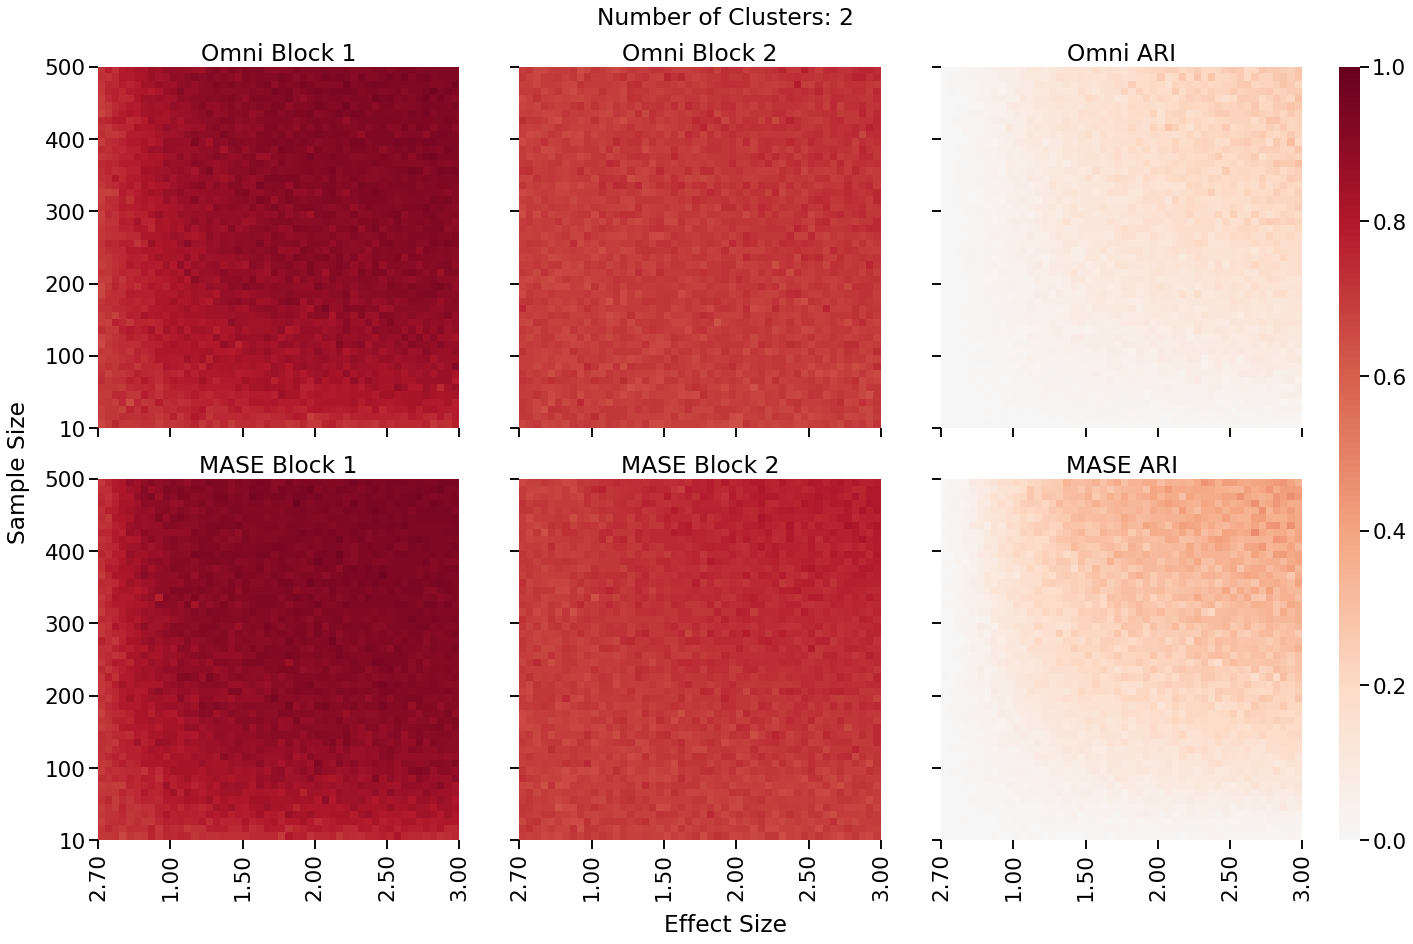

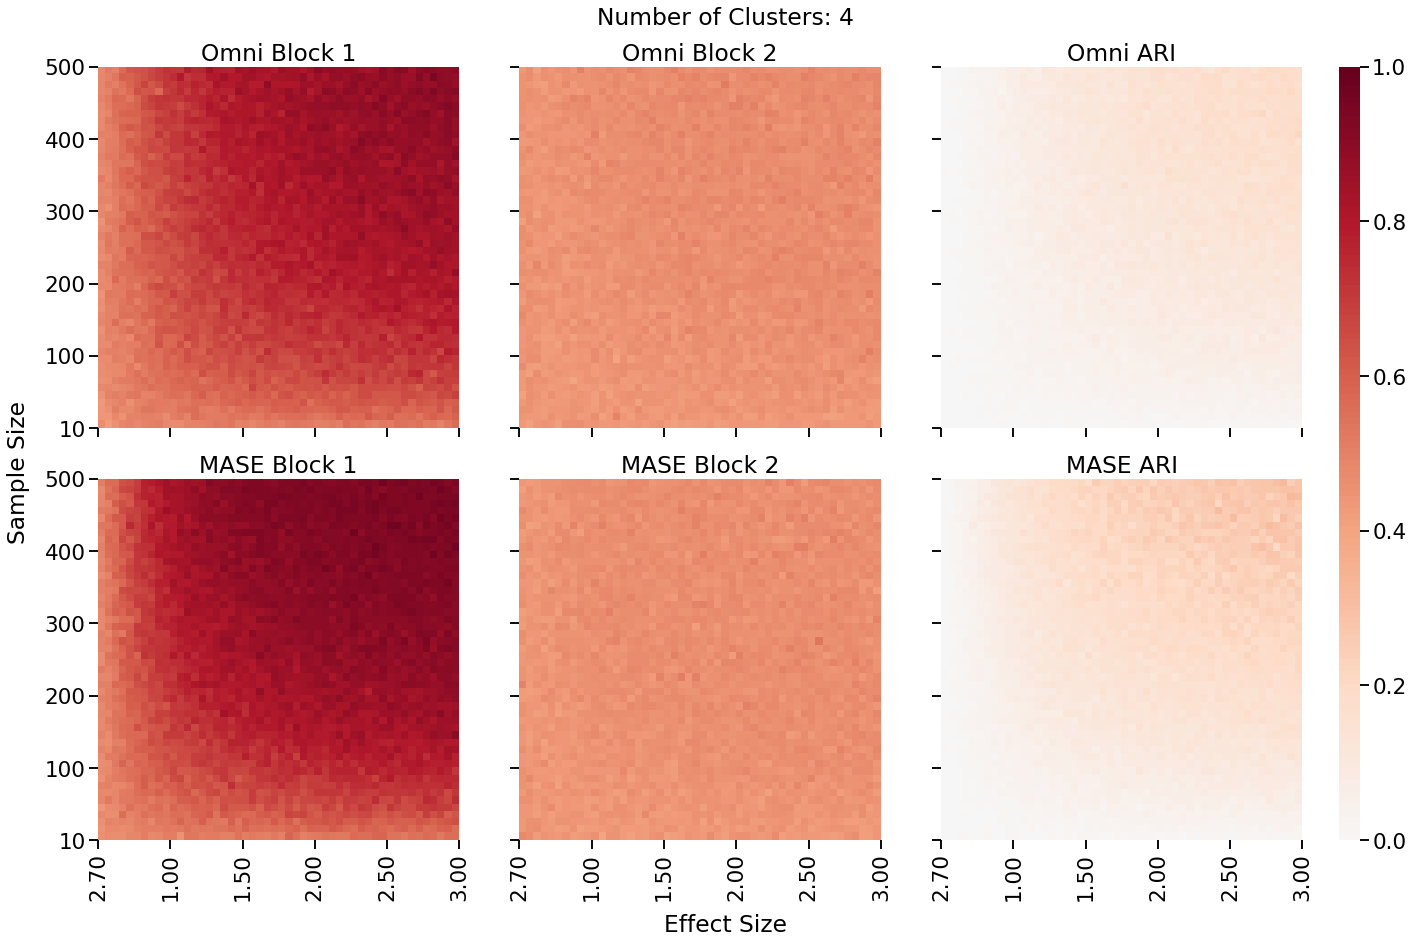

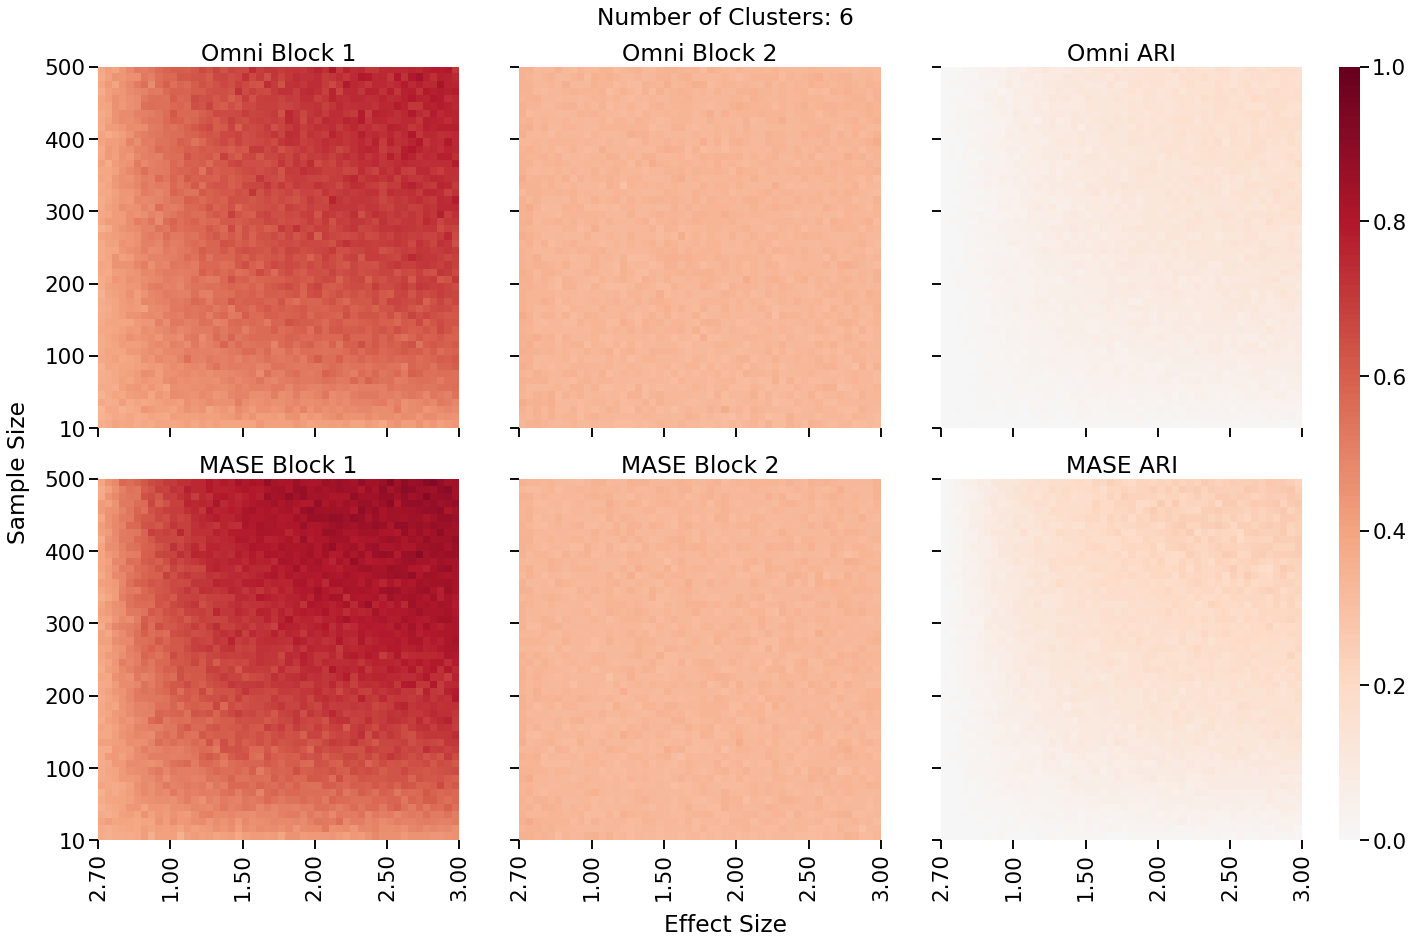

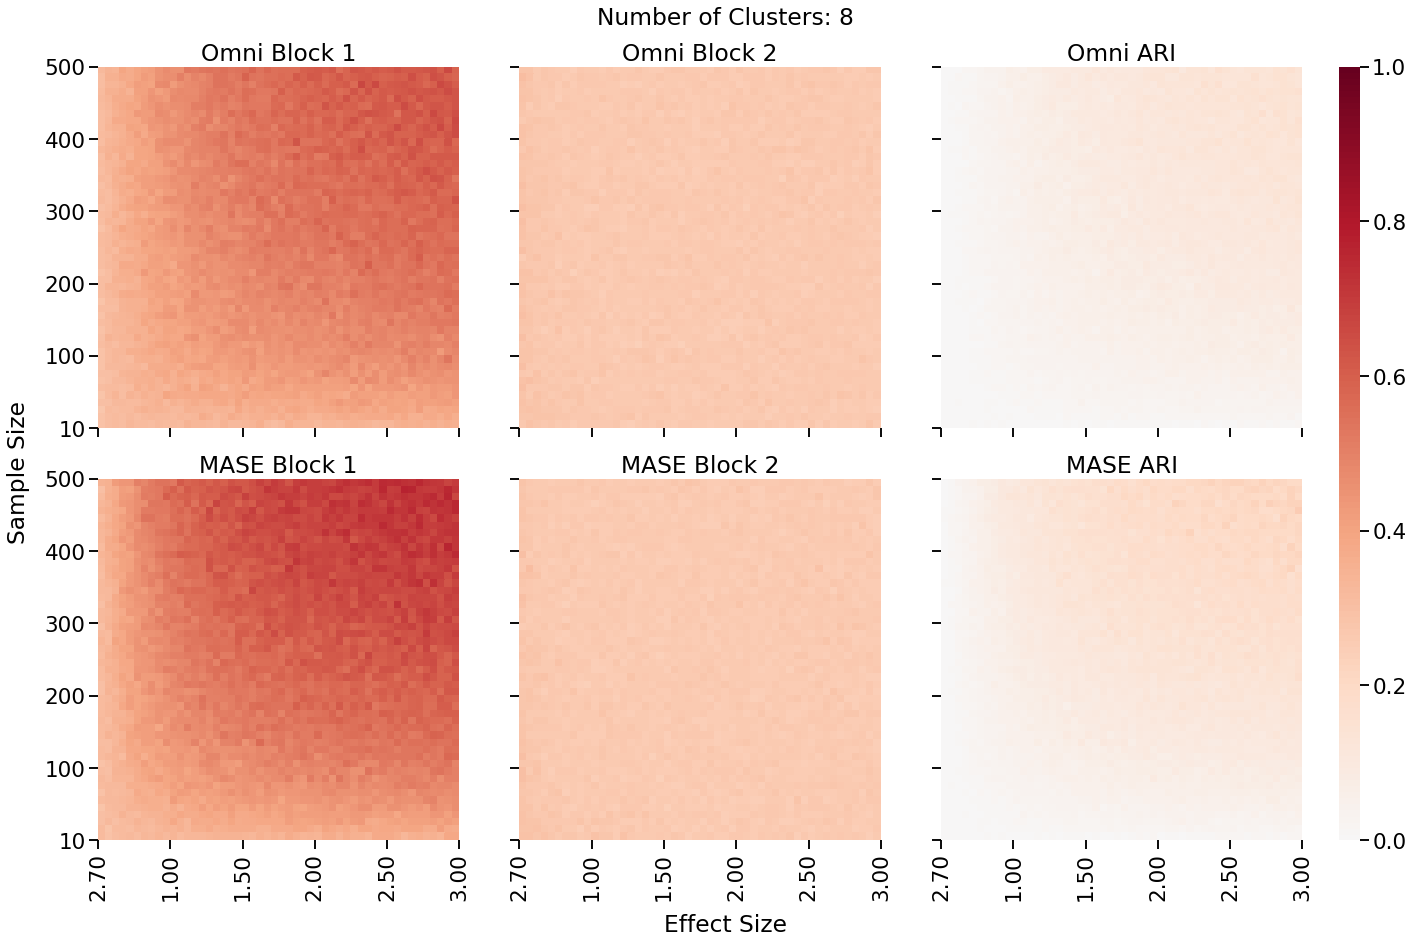

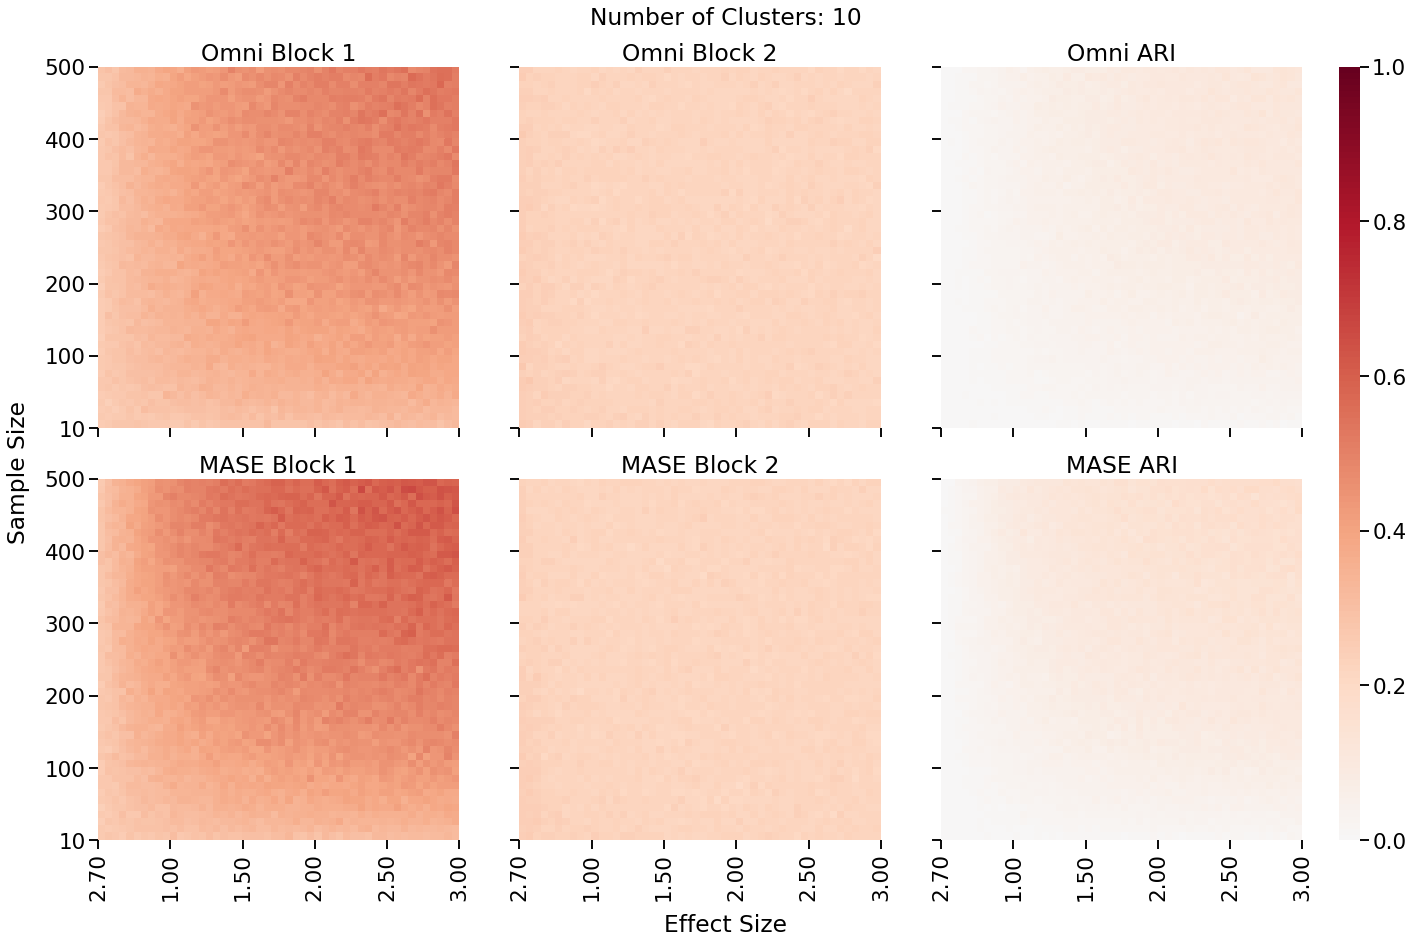

<IPython.core.display.Javascript object>

In [24]:
rows = ["omni", "mase"]
cols = ["_correct_nodes_1_", "_correct_nodes_2_", "_ari_"]

xticklabels = var_2s[::10]
xticklabels[0] += 0.55
yticklabels = np.linspace(0, 250, spacing + 1)[::10] * 2
yticklabels[0] += 10

for k in range(2, 11, 2):
    # Make figure with correct subplots
    sns.set_context("talk", font_scale=1.3)
    fig, ax = plt.subplots(
        2,
        4,
        gridspec_kw={"width_ratios": [1, 1, 1, 0.05]},
        figsize=(19, 12),
        sharex=True,
        sharey=True,
        constrained_layout=True,
    )
    gs = ax[-1, -1].get_gridspec()
    for ax_ in ax[:, -1]:
        ax_.remove()
    ax_leg = fig.add_subplot(gs[:, -1])

    for i, method in enumerate(rows):
        for j, metric in enumerate(cols):
            sns.heatmap(
                np.flipud(res_df[f"{method}{metric}{k}"].values.reshape(spacing, -1)),
                ax=ax[i, j],
                square=True,
                center=0,
                cmap="RdBu_r",
                cbar_kws=dict(shrink=0.7),
                xticklabels=["{:.2f}".format(x) for x in xticklabels],
                yticklabels=["{:.0f}".format(y) for y in yticklabels],
                cbar_ax=ax_leg,
                vmin=0,
                vmax=1,
            )
            ax[i, j].set_xticks(np.arange(0, ax[0, 0].get_xlim()[1] + 1, 10))
            ax[i, j].set_yticks(np.arange(0, ax[0, 0].get_ylim()[0] + 1, 10)[::-1])

            if i == 0:
                row_name = "Omni"
            else:
                row_name = "MASE"
            if j == 0:
                col_name = "Block 1"
            elif j == 1:
                col_name = "Block 2"
            else:
                col_name = "ARI"
            ax[i, j].set_title(f"{row_name} {col_name}")

    fig.text(0.5, 1.025, f"Number of Clusters: {k}", va="center", ha="center")
    fig.text(-0.025, 0.5, "Sample Size", va="center", rotation="vertical")
    fig.text(0.5, -0.025, "Effect Size", va="center", ha="center")

    fig.savefig(
        f"./figures/20200216_weighted_correct_nodes_k={k}.png",
        dpi=300,
        bbox_inches="tight",
    )